In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

import seaborn as sns
sns.set_theme()

import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import linear_model

In [2]:
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
cpcbColumns = ['pm2_5', 'pm10']

def getRawData():
    allData = "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/db.csv"
    densityStatsOnly = "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/densityStats.csv"
    sensorData = pd.read_csv(allData,sep=',')
    densityStats = pd.read_csv(densityStatsOnly,sep=',') 
    
    cpcbLinks = [
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/naja_pollutants.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/naja_meter.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/okla_pollutants.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/okla_meter.csv"
    ]

    okla_pollutants = pd.read_csv(cpcbLinks[2],sep=',')
    okla_meter = pd.read_csv(cpcbLinks[3],sep=',')
    naja_pollutants = pd.read_csv(cpcbLinks[0],sep=',')
    naja_meter = pd.read_csv(cpcbLinks[1],sep=',')
    
    return sensorData,okla_pollutants,okla_meter,naja_pollutants,naja_meter

def combineCPCB(okla_pollutants,okla_meter,naja_pollutants,naja_meter):
    okla_cpcb = pd.merge(okla_pollutants, okla_meter, on='To Date', how='outer')
    naja_cpcb = pd.merge(naja_pollutants, naja_meter, on='To Date', how='outer')
    
    naja_cpcb = naja_cpcb.rename(columns={'To Date': 'timestamp', 'PM2.5': 'pm2_5','PM10': 'pm10'})
    okla_cpcb = okla_cpcb.rename(columns={'To Date': 'timestamp', 'PM2.5': 'pm2_5','PM10': 'pm10'})
    
    for i in cpcbColumns:
        naja_cpcb[i] = pd.to_numeric(naja_cpcb[i], errors='coerce')
        okla_cpcb[i] = pd.to_numeric(okla_cpcb[i], errors='coerce')
    cpcbData = {"najafgarh":naja_cpcb,"okhla":okla_cpcb}
    return cpcbData
    
def partDataByLoc(sensorData,cpcbData):
    allData = {}
    for loc in sensorlocations:
        allData[loc] = sensorData[sensorData["location"]==loc].copy()
    allData["najafgarh"] = cpcbData["najafgarh"]
    allData["okhla"] = cpcbData["okhla"]
    return allData

def convertTimeStamp(allData):
    format="%m/%d/%Y"
    for location in allData:
        allData[location]['timestamp'] = (allData[location]["timestamp"].apply(lambda d: pd.to_datetime(str(d))))
        allData[location] = allData[location].sort_values(by='timestamp',ascending=True)
        allData[location] = allData[location].set_index('timestamp')
        allData[location]["timestamp"] = allData[location].index
    return allData

### Get Raw Data (download step, run once only)

In [3]:
sensorData,okla_pollutants,okla_meter,naja_pollutants,naja_meter = getRawData()

### Everything below OK

In [4]:
cpcbData = combineCPCB(okla_pollutants,okla_meter,naja_pollutants,naja_meter)
allData = partDataByLoc(sensorData,cpcbData)
allData = convertTimeStamp(allData)

### Run Once Only

In [5]:
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]

def getIntForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    return (timeFromStart) / 24.0
def getFractionalDayForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    fractionDay = (timeFromStart) / 24.0
    if(row["timestamp"].month==10):
        return row["timestamp"].day + fractionDay
    else:
        return 31.0 + row["timestamp"].day + fractionDay
    
for locs in allLocations:
    allData[locs].loc[:,"integerTime"] = allData[locs].apply(lambda row: getIntForTimeDate(row), axis=1)
    allData[locs].loc[:,"fractionalDay"] = allData[locs].apply(lambda row: getFractionalDayForTimeDate(row), axis=1)

In [95]:
ROLL_MEAN_POINTS = 3600
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
# sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
for locs in allLocations:
    for i in sensorParameters:
        if i in allData[locs].columns:
            allData[locs]["roll_" + i] = allData[locs][i].rolling(ROLL_MEAN_POINTS).mean().shift(-ROLL_MEAN_POINTS//2)

KeyError: 'fractionalDay'

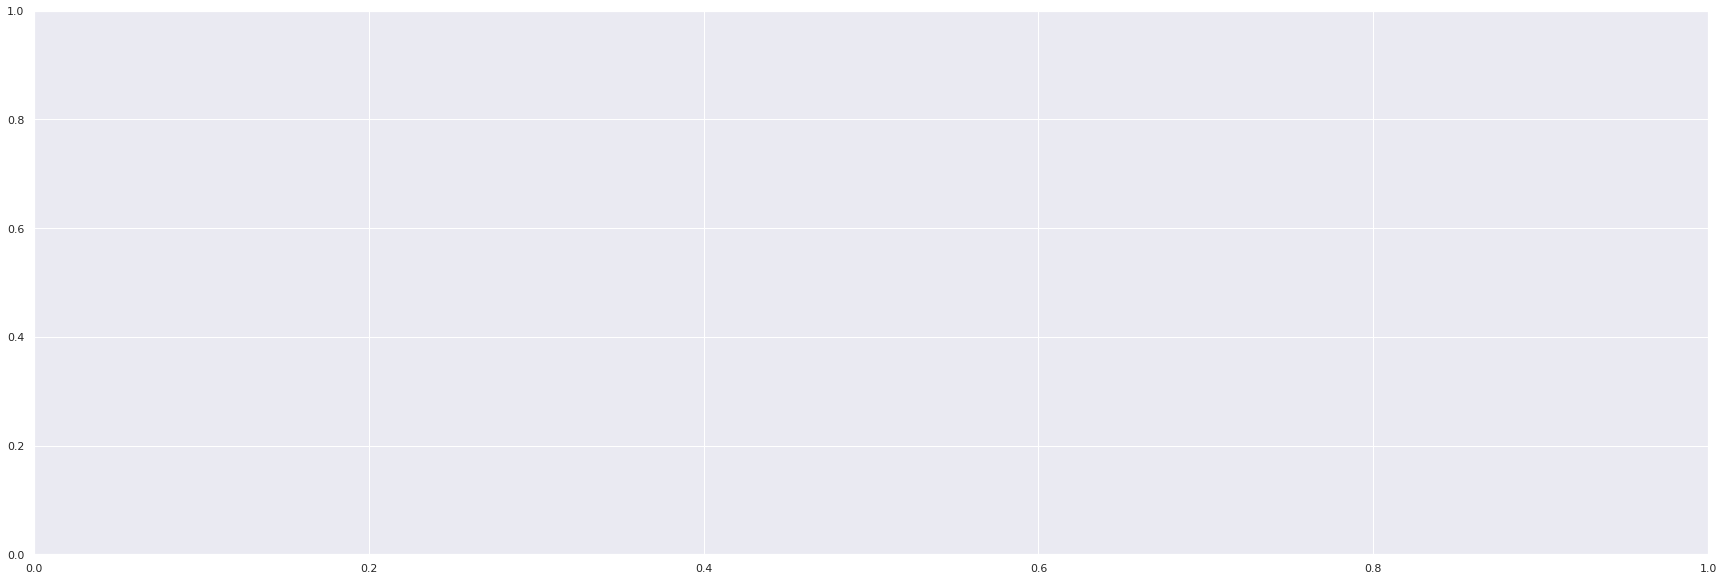

In [142]:
# fig, ax = plt.subplots(6,1,figsize=(30,60))
for i in range(2):
    x_ticks = map(lambda d: str(int(d))+' Oct' if d < 32.0 else str(int(d)-32)+' Nov', range(1,37))
    fig, ax = plt.subplots(figsize=(30, 10))
    vx1 = allData[cpcbLocations[i]]['fractionalDay']
    vx2 = allData[cpcbLocations[i]]['roll_pm2_5']
    vx3 = allData[cpcbLocations[i]]['roll_pm10']
    mask = ~np.isnan(vx1) & ~np.isnan(vx2)
    s1, i1, r_value, p_value, std_err = stats.linregress(vx1[mask],vx2[mask])
    
    s2, i2, r_value, p_value, std_err = stats.linregress(vx1[mask],vx3[mask])
    
    
    print(cpcbLocations[i],"{:.2f}".format(s1),"{:.2f}".format(s2))
    g = sns.regplot(x="fractionalDay", y="roll_pm2_5", data=allData[cpcbLocations[i]],ax=ax, label="pm 2.5 : "+"{:.2f}".format(s1))
    g = sns.regplot(x="fractionalDay", y="roll_pm10", data=allData[cpcbLocations[i]],ax=ax, label="pm 10: "+"{:.2f}".format(s2))
    g.set_xticks(range(1,37))
    g.set_xticklabels(x_ticks)
    g.legend(title='slope: change per day',loc='upper left', borderpad=.2)
    ax.set(xlabel='Day', ylabel='PM2.5')
    ax.set_title(cpcbLocations[i]+" (CPCB) Monthly Trend")
    plt.show()

In [ ]:
# fig, ax = plt.subplots(6,1,figsize=(30,60))
for i in range(6):
    x_ticks = map(lambda d: str(int(d))+' Oct' if d < 32.0 else str(int(d)-32)+' Nov', range(1,37))
    fig, ax = plt.subplots(figsize=(30, 10))
    vx1 = allData[sensorlocations[i]]['fractionalDay']
    vx2 = allData[sensorlocations[i]]['roll_pm2_5']
    vx3 = allData[sensorlocations[i]]['roll_pm10']
    vx4 = allData[sensorlocations[i]]['roll_pm1_0']
    mask = ~np.isnan(vx1) & ~np.isnan(vx2)
    s1, i1, r_value, p_value, std_err = stats.linregress(vx1[mask],vx2[mask])
    
    s2, i2, r_value, p_value, std_err = stats.linregress(vx1[mask],vx3[mask])
    
    s3, i3, r_value, p_value, std_err = stats.linregress(vx1[mask],vx4[mask])
    
    print(sensorlocations[i],"{:.2f}".format(s1),"{:.2f}".format(s2),"{:.2f}".format(s3))
    g = sns.regplot(x="fractionalDay", y="roll_pm2_5", data=allData[sensorlocations[i]],ax=ax, label="pm 2.5 : "+"{:.2f}".format(s1))
    g = sns.regplot(x="fractionalDay", y="roll_pm10", data=allData[sensorlocations[i]],ax=ax, label="pm 10: "+"{:.2f}".format(s2))
    g = sns.regplot(x="fractionalDay", y="roll_pm1_0", data=allData[sensorlocations[i]],ax=ax, label="pm 1.0: "+"{:.2f}".format(s3))
    g.set_xticks(range(1,37))
    g.set_xticklabels(x_ticks)
    g.legend(title='slope: change per day',loc='upper left', borderpad=.2)
    ax.set(xlabel='Day', ylabel='PM2.5')
    ax.set_title(sensorlocations[i]+" Monthly Trend")
    plt.show()

In [141]:
x1 = allData["Jharoda_Kalan"]["pm2_5"].resample('4H').mean()
x2 = allData["najafgarh"]["pm2_5"].resample('4H').mean()
x2

timestamp
2021-01-10 00:00:00    37.266667
2021-01-10 04:00:00    41.687500
2021-01-10 08:00:00    42.812500
2021-01-10 12:00:00    26.875000
2021-01-10 16:00:00    31.062500
                         ...    
2021-12-10 04:00:00    65.937500
2021-12-10 08:00:00    66.000000
2021-12-10 12:00:00    24.312500
2021-12-10 16:00:00    25.500000
2021-12-10 20:00:00    58.062500
Freq: 4H, Name: pm2_5, Length: 2010, dtype: float64